In [10]:

import os
import pandas as pd
metadata_path = 'C:/Users/kingGester/Desktop/data/raw/metadata.csv'
meta = pd.read_csv(metadata_path)


def get_full_path(row):
    folder = 'train' if row['sn'] <= 4 else 'test'
    return f"C:/Users/kingGester/Desktop/data/raw/{folder}/{row['filename']}"

meta['full_path'] = meta.apply(get_full_path, axis=1)


train_data = meta[meta['sn'] <= 4]


def process_test_file(file_path, target_column='thrust'):
    if not os.path.exists(file_path):
        print(f"🚨 فایل {file_path} پیدا نشد.")
        return None
    try:
        df = pd.read_csv(file_path)
        if target_column not in df.columns:
            print(f"❌ ستون {target_column} در فایل {file_path} وجود ندارد.")
            return None

        df = df[['ton', target_column]].copy()
        df.dropna(inplace=True)

        # ویژگی on_duration
        on_duration = []
        count = 0
        for ton in df['ton']:
            if ton == 1:
                count += 1
            else:
                count = 0
            on_duration.append(count)
        df['on_duration'] = on_duration

        # ویژگی lag thrust
        df['lag_thrust_1'] = df[target_column].shift(1)
        df.dropna(inplace=True)

        df['source_file'] = file_path
        return df

    except Exception as e:
        print(f"🚨 خطا در فایل {file_path}: {e}")
        return None







all_train_frames = []  

for idx, row in train_data.iterrows():
    file_path = row['full_path']
    sn_value = row['sn']  

    df = process_test_file(file_path, target_column='thrust')
    if df is not None:
        df['sn'] = sn_value  
        all_train_frames.append(df)


df_train = pd.concat(all_train_frames, ignore_index=True)
df_train.head()


,ton,thrust,on_duration,lag_thrust_1,source_file,sn
0,0,-0.000250,0,-0.003521,C:/Users/kingGester/Desktop/data/raw/train/000...,1
1,0,-0.002765,0,-0.000250,C:/Users/kingGester/Desktop/data/raw/train/000...,1
2,0,0.000846,0,-0.002765,C:/Users/kingGester/Desktop/data/raw/train/000...,1
3,0,0.003115,0,0.000846,C:/Users/kingGester/Desktop/data/raw/train/000...,1
4,0,0.001580,0,0.003115,C:/Users/kingGester/Desktop/data/raw/train/000...,1


In [2]:
# ساخت rolling average (میانگین thrust در 5 مرحله اخیر)
df_train['rolling_avg_thrust'] = df_train['thrust'].rolling(window=5).mean()

# ساخت cumulative on_time (کل زمان روشن بودن از ابتدا)
df_train['cumulative_on_time'] = df_train['ton'].cumsum()

# حذف سطرهای اولیه‌ای که rolling خالی دارن
df_train.dropna(inplace=True)

# بررسی
df_train[['ton', 'on_duration', 'lag_thrust_1', 'rolling_avg_thrust', 'cumulative_on_time', 'thrust']].head()


,ton,on_duration,lag_thrust_1,rolling_avg_thrust,cumulative_on_time,thrust
4,0,0,0.003115,0.000505,0,0.001580
5,0,0,0.001580,0.000246,0,-0.001546
6,0,0,-0.001546,0.001824,0,0.005123
7,0,0,0.005123,0.002552,0,0.004487
8,0,0,0.004487,0.001723,0,-0.001029


In [3]:
serial_numbers = df_train['sn'].unique()


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import numpy as np

features = ['ton', 'on_duration', 'lag_thrust_1', 'rolling_avg_thrust', 'cumulative_on_time']
X_all = df_train[features].to_numpy()
y_all = df_train['thrust'].to_numpy()

BATCH_SIZE = 1_000_000  
n_samples = X_all.shape[0]

for i in range(0, n_samples, BATCH_SIZE):
    start_idx = i
    end_idx = min(i + BATCH_SIZE, n_samples)

    batch_X = X_all[start_idx:end_idx]
    batch_y = y_all[start_idx:end_idx]


    X_train, X_val, y_train, y_val = train_test_split(batch_X, batch_y, test_size=0.2, random_state=42)

    model_xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    )

    model_xgb.fit(X_train, y_train)

    y_pred_xgb = model_xgb.predict(X_val)

    print(f"Batch {i//BATCH_SIZE + 1}:")
    print("  📊 MAE:", mean_absolute_error(y_val, y_pred_xgb))
    print("  📈 R² Score:", r2_score(y_val, y_pred_xgb))



Batch 1:
  📊 MAE: 0.030671767724274643
  📈 R² Score: 0.9814222571828659
Batch 2:
  📊 MAE: 0.03627504047055385
  📈 R² Score: 0.9772433298372597
Batch 3:
  📊 MAE: 0.027379081884687427
  📈 R² Score: 0.9805868037256964
Batch 4:
  📊 MAE: 0.01774150239395345
  📈 R² Score: 0.9814562025066567
Batch 5:
  📊 MAE: 0.01486785662510753
  📈 R² Score: 0.9823228076412546
Batch 6:
  📊 MAE: 0.02007783654537118
  📈 R² Score: 0.9807902647098988
Batch 7:
  📊 MAE: 0.009063148923307762
  📈 R² Score: 0.9805639104608069
Batch 8:
  📊 MAE: 0.02633402919205785
  📈 R² Score: 0.9814896511872956
Batch 9:
  📊 MAE: 0.032788386713864304
  📈 R² Score: 0.9805020788937009
Batch 10:
  📊 MAE: 0.030490633774392782
  📈 R² Score: 0.9781741852399485
Batch 11:
  📊 MAE: 0.01692503519431131
  📈 R² Score: 0.9800419091311777
Batch 12:
  📊 MAE: 0.013084393792360934
  📈 R² Score: 0.9814454761218351
Batch 13:
  📊 MAE: 0.019928354264894418
  📈 R² Score: 0.9795829434671434
Batch 14:
  📊 MAE: 0.009010448258718967
  📈 R² Score: 0.9812463527

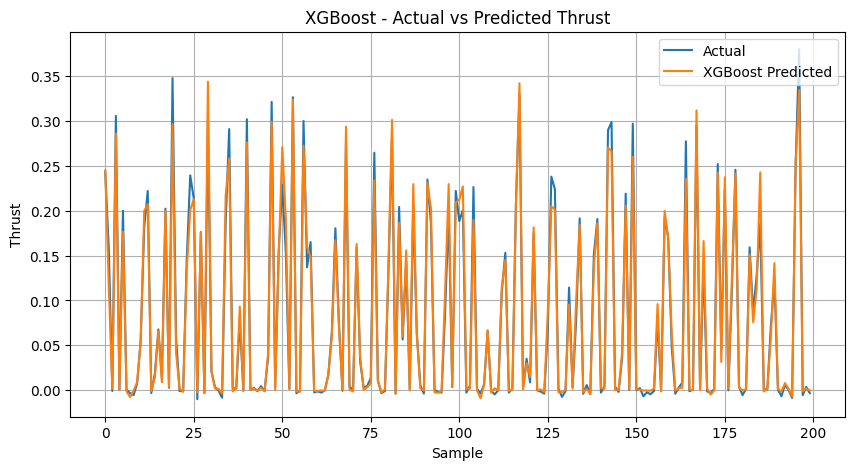

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_val[:200], label='Actual')
plt.plot(y_pred_xgb[:200], label='XGBoost Predicted')
plt.title("XGBoost - Actual vs Predicted Thrust")
plt.xlabel("Sample")
plt.ylabel("Thrust")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# آموزش نهایی مدل XGBoost روی کل داده‌ها (نه به صورت batch)
X_all = df_train[features]
y_all = df_train['thrust']

final_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
final_model.fit(X_all, y_all)


import os
import joblib


os.makedirs('models', exist_ok=True)

joblib.dump(final_model, 'models/xgb_final_model.joblib')


['models/xgb_final_model.joblib']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
y_pred = final_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"📊 MAE: {mae:.4f}")
print(f"📈 R²: {r2:.4f}")


📊 MAE: 0.0221
📈 R²: 0.9804


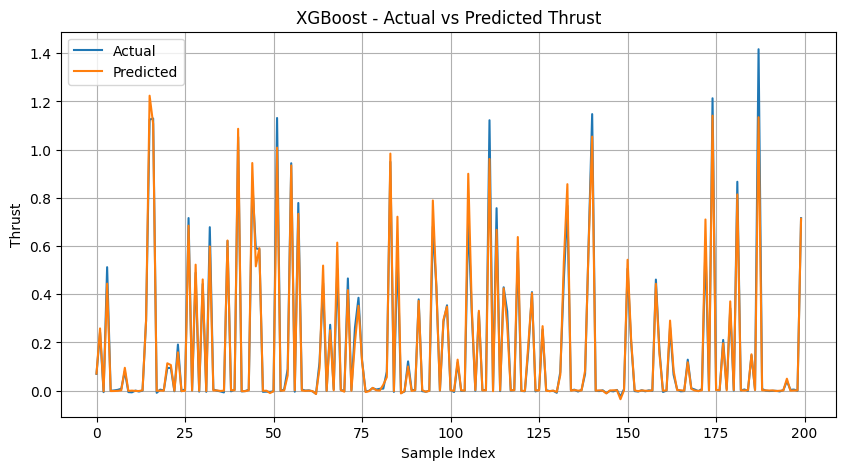

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_val[:200].to_numpy(), label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.title("XGBoost - Actual vs Predicted Thrust")
plt.xlabel("Sample Index")
plt.ylabel("Thrust")
plt.legend()
plt.grid(True)
plt.show()


## ✨ گام بعدی – نوت‌بوک 04: مدل‌سازی جداگانه برای هر SN

در مرحله‌ی بعد، با استفاده از همان ویژگی‌ها، برای هر SN یک مدل جداگانه آموزش داده خواهد شد (SN01 تا SN12).  
هدف از این کار، افزایش دقت مدل برای هر رانشگر با درنظر گرفتن شرایط خاص آن است.
